In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from model import *

import matplotlib.pyplot as plt

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

Define the dimensions and constants of the system we're working with:

In [3]:
x_dim = 2
u_dim = 1
layer_sizes = [32,32]
n_heads = 2

lr = 2e-4
beta1 = 0.9

batch_size = 50

Define the model and loss

In [4]:
x_ = tf.placeholder(tf.float32, shape=(None, x_dim))
u_ = tf.placeholder(tf.float32, shape=(None, u_dim))
xp_ = tf.placeholder(tf.float32, shape=(None, x_dim))
index_ = tf.placeholder(tf.int32, shape=(None,))

x_pred = multi_head_predictor(x_,u_,layer_sizes,n_heads)

In [5]:
loss_ = multi_head_loss(x_pred, xp_, index_, n_heads)

[2, None, 1]


In [6]:
saver = tf.train.Saver()
save_path = "model/test2"

Define the optimizer

In [7]:
optim = tf.train.AdamOptimizer(lr, beta1, name="optim")
train_op = optim.minimize(loss_)

In [8]:
writer = tf.summary.FileWriter(save_path + '/train', sess.graph)

Gather some data

In [9]:
x_data = np.random.randn(200).reshape([100,2])
u_data = np.zeros([100,1])
y1 = lambda x_data: np.stack([np.cos(x_data[:,0]), np.sin(x_data[:,1])], axis=1)
y2 = lambda x_data: np.stack([2*np.cos(x_data[:,0]), np.sin(x_data[:,1])], axis=1)
# y1 = lambda x_data: x_data+1
# y2 = lambda x_data: 2*x_data
y1_data = y1(x_data) 
y2_data = y2(x_data)

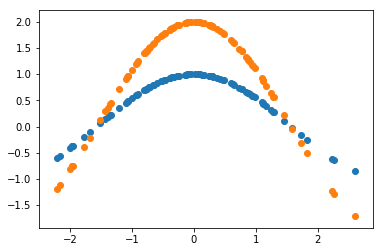

In [10]:
plt.figure()
plt.scatter(x_data[:,0], y1_data[:,0])
plt.scatter(x_data[:,0], y2_data[:,0])
plt.show()

In [11]:
x_input = np.concatenate([x_data, x_data])
u_input = np.zeros([200,1])
target_data = np.concatenate([y1_data, y2_data])
indices = np.concatenate([np.zeros(100, dtype='int32'), np.ones(100,dtype='int32')]) #.reshape([200,1])
N = 200

Run and train the model on the data:

In [12]:
tf.global_variables_initializer().run()

In [18]:
for epoch in range(500):
    random_idx = np.random.permutation(N)
    num_batches = N // batch_size
    for i in range(num_batches):
        batch_idx = random_idx[range(i*batch_size,(i+1)*batch_size)]
        x_batch = x_input[batch_idx,:]
        u_batch = u_input[batch_idx,:]
        target_batch = target_data[batch_idx,:]
        ind_batch = indices[batch_idx]
        
        inputs = {x_: x_batch,
                  u_: u_batch,
                  xp_: target_batch,
                  index_: ind_batch}
        
        _, loss = sess.run((train_op, loss_), feed_dict=inputs)
        
    if epoch %  == 0:
            print('Epoch',epoch,'\tBatch',i,'\tLoss:',loss)

Epoch 0 	Batch 0 	Loss: 15.1553
Epoch 1 	Batch 0 	Loss: 13.589
Epoch 2 	Batch 0 	Loss: 13.8817
Epoch 3 	Batch 0 	Loss: 17.1407
Epoch 4 	Batch 0 	Loss: 14.4563
Epoch 5 	Batch 0 	Loss: 19.1323
Epoch 6 	Batch 0 	Loss: 17.057
Epoch 7 	Batch 0 	Loss: 15.7026
Epoch 8 	Batch 0 	Loss: 15.8164
Epoch 9 	Batch 0 	Loss: 14.4232
Epoch 10 	Batch 0 	Loss: 13.707
Epoch 11 	Batch 0 	Loss: 15.1276
Epoch 12 	Batch 0 	Loss: 14.3025
Epoch 13 	Batch 0 	Loss: 19.3847
Epoch 14 	Batch 0 	Loss: 16.1447
Epoch 15 	Batch 0 	Loss: 11.1941
Epoch 16 	Batch 0 	Loss: 14.0658
Epoch 17 	Batch 0 	Loss: 18.0119
Epoch 18 	Batch 0 	Loss: 17.469
Epoch 19 	Batch 0 	Loss: 10.0588
Epoch 20 	Batch 0 	Loss: 13.0305
Epoch 21 	Batch 0 	Loss: 12.8381
Epoch 22 	Batch 0 	Loss: 10.5068
Epoch 23 	Batch 0 	Loss: 15.4969
Epoch 24 	Batch 0 	Loss: 11.0044
Epoch 25 	Batch 0 	Loss: 13.8978
Epoch 26 	Batch 0 	Loss: 8.44103
Epoch 27 	Batch 0 	Loss: 12.9959
Epoch 28 	Batch 0 	Loss: 8.78122
Epoch 29 	Batch 0 	Loss: 12.0546
Epoch 30 	Batch 0 	Loss:

In [19]:
saver.save(sess, save_path)

'model/test2'

In [20]:
x_test = np.random.randn(200).reshape([100,2])
u_test = np.zeros([100,1])
y1_test = y1(x_test)
y2_test = y2(x_test)

In [21]:
x_pred_test = sess.run(x_pred, {x_: x_test, u_: u_test})

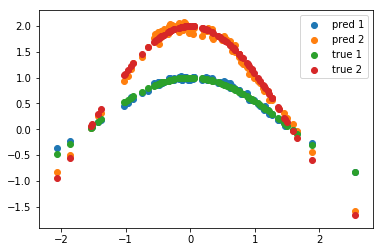

In [22]:
plt.figure()
plt.scatter(x_test[:,0], x_pred_test[0,:,0], label="pred 1")
plt.scatter(x_test[:,0], x_pred_test[1,:,0], label="pred 2")
plt.scatter(x_test[:,0], y1_test[:,0], label="true 1")
plt.scatter(x_test[:,0], y2_test[:,0], label="true 2")
plt.legend()
plt.show()